In [10]:
# Hidden Config Cell

#!python -m pip install -e ../../../../Maccabee > /dev/null

from maccabee.constants import Constants
from maccabee.data_sources.data_source_builders import build_random_normal_datasource
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid
from maccabee.modeling.models import LinearRegressionCausalModel

from functools import partial

from maccabee.data_generation.utils import CompiledExpression, evaluate_expression
import sympy
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from time import time
from collections import defaultdict
from itertools import combinations
from functools import reduce

LOW, MEDIUM, HIGH = Constants.AxisLevels.LEVELS

param_grid = {
    Constants.AxisNames.TREATMENT_NONLINEARITY: [HIGH],
    Constants.AxisNames.OUTCOME_NONLINEARITY: [HIGH]
}

normal_data_source = build_random_normal_datasource(
    n_covars=20,
    n_observations=100)
    
run_benchmark = partial(benchmark_model_using_sampled_dgp_grid,
    model_class=LinearRegressionCausalModel,
    estimand=Constants.Model.ATE_ESTIMAND,
    data_source=normal_data_source,
    dgp_param_grid=param_grid)

run_parallelization_benchmark = partial(
    run_benchmark,
    num_dgp_samples=16,
    num_sampling_runs_per_dgp=1,
    num_samples_from_dgp=5)

run_compilation_benchmark = partial(
    run_benchmark,
    num_dgp_samples=1,
    num_sampling_runs_per_dgp=1,
    n_jobs=8)

def mean_exec_time(lmbda, n_averaging_runs):
    times = []
    for _ in range(n_averaging_runs):
        start_time = time()
        proc = mp.Process(target=lmbda)
        proc.start()
        proc.join()
        exc_time = time() - start_time
        proc.close()
        times.append(exc_time)
    
    return np.mean(times)

In [2]:
%%time

_ = run_parallelization_benchmark(n_jobs=1)

CPU times: user 5.67 s, sys: 121 ms, total: 5.79 s
Wall time: 1min 9s


In [3]:
%%time

_ = run_parallelization_benchmark(n_jobs=4)

CPU times: user 5.62 s, sys: 147 ms, total: 5.76 s
Wall time: 35.7 s


In [19]:
n_symbols = 33
n_obs = 1000

# Generate the symbols that make up the expressions
symbol_names = [f"x{i}" for i in range(n_symbols)]
symbols = sympy.symbols(symbol_names)

# Generate the test data used to evaluate the expression
data = np.random.normal(size=(n_obs, n_symbols))
data_df = pd.DataFrame(data, columns=symbol_names)

# Generate a set of terms akin to those used in Maccabee sampling
terms = symbols + \
    [symbol**2 for symbol in symbols] + \
    [symbol**3 for symbol in symbols] + \
    [reduce(lambda x, y: x*y, comb) for comb in combinations(symbols, 2)] + \
    [reduce(lambda x, y: x*y, comb) for comb in combinations(symbols, 3)]

print(len(terms), "unique terms") 

# Define the term counts for the benchmark
n_term_levels = np.linspace(1, 6*1e3, 10).astype(int)

compile_times = []
compiled_eval_times = []
uncompiled_eval_times = []
      
# Collect timing for all num term levels
for n_terms in n_term_levels:
    print("Running for", n_terms, "terms: ", end="")
    expr = np.sum(np.random.choice(terms, n_terms, replace=True))
    
    compiled_expr_lmbda = lambda: CompiledExpression(expr, symbols)
    compile_times.append(mean_exec_time(compiled_expr_lmbda, 2))
    print(".", end="")
    
    compile_expr = CompiledExpression(expr, symbols, background_compile=True)
    compiled_evaluate_lmbda = lambda: evaluate_expression(compile_expr, data_df)
    compiled_eval_times.append(mean_exec_time(compiled_evaluate_lmbda, 25))
    print(".", end="")
    
    uncompiled_evaluate_lmbda = lambda: evaluate_expression(expr, data_df)
    uncompiled_eval_times.append(mean_exec_time(uncompiled_evaluate_lmbda, 25))
    print(".", end="\n")

6083 unique terms
Running for 1 terms: ...
Running for 667 terms: ...
Running for 1334 terms: ...
Running for 2000 terms: ...
Running for 2667 terms: ...
Running for 3333 terms: ...
Running for 4000 terms: ...
Running for 4666 terms: ...
Running for 5333 terms: ...
Running for 6000 terms: ...


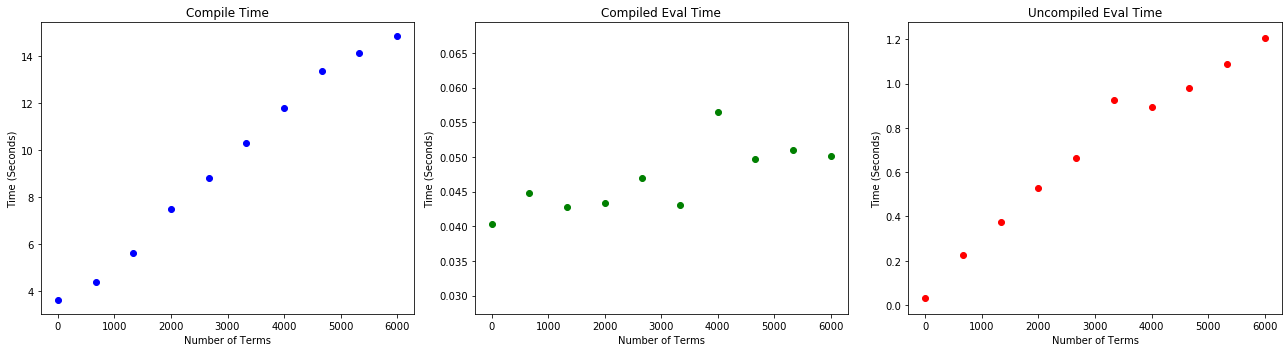

In [28]:
def n_term_time_count(n_terms, times, title, color):
    plt.scatter(n_terms, times, color=color)
    plt.xlabel("Number of Terms")
    plt.ylabel("Time (Seconds)")
    plt.title(title)

plt.figure(figsize=(18, 5))
plt.subplot(131)
n_term_time_count(n_term_levels, compile_times, "Compile Time", "b")
plt.subplot(132)
n_term_time_count(n_term_levels, compiled_eval_times, "Compiled Eval Time", "g")
plt.subplot(133)
n_term_time_count(n_term_levels, uncompiled_eval_times, "Uncompiled Eval Time", "r")
plt.tight_layout()
plt.show()

In [48]:
def term_time_counts_at_n_samples(n_terms, n_samples,
                                  compile_time, compiled_eval, uncompiled_eval):
    
    compile_total = np.array(compile_time) + n_samples*np.array(compiled_eval)
    uncompile_total = n_samples*np.array(uncompiled_eval)
    
    plt.scatter(n_terms, compile_total, color="b", label="Compiled")
    plt.scatter(n_terms, uncompile_total, color="r", label="Uncompiled")
    
    try:
        cross_index = np.where(uncompile_total - compile_total > 0)[0][0]
        cross_term_count = n_terms[cross_index]
        plt.axvline(x=cross_term_count,
                    label=f"Crossover Point. Terms={cross_term_count}")
    except:
        pass
    
    plt.title(f"Cummulative Expected Time\nfor {n_samples} Data Sample per DGP")
    plt.xlabel("Number of Terms")
    plt.ylabel("Time (Seconds)")
    plt.legend()

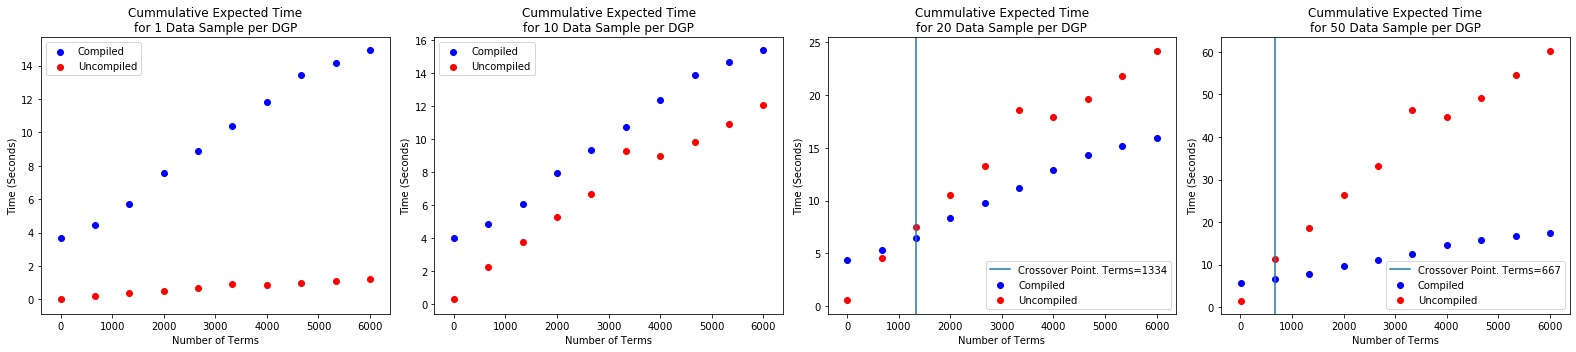

In [46]:
plt.figure(figsize=(22, 5))
for i, n_samples in enumerate([1, 10, 20, 50]):
    plt.subplot(141 + i)
    term_time_counts_at_n_samples(n_term_levels, n_samples,
                                  compile_times, compiled_eval_times,
                                  uncompiled_eval_times)
plt.tight_layout()
plt.show()

In [56]:
N_samples = [10, 50, 100, 200, 500]
times = defaultdict(list)
for n_samples in N_samples:
    for compiled in [True, False]:
        s = time()
        run_compilation_benchmark(
            num_samples_from_dgp=n_samples,
            compile_functions=compiled)
        e = time()
        exec_time = e - s
        times[compiled].append(exec_time)


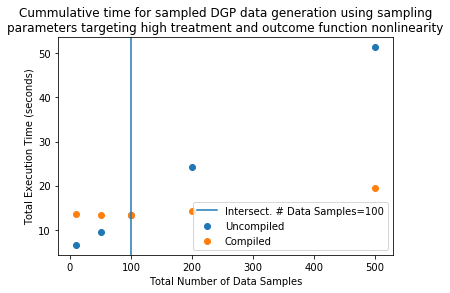

In [63]:
plt.scatter(N_samples, times[False], label="Uncompiled")
plt.scatter(N_samples, times[True], label="Compiled")
plt.legend()
plt.title("Cummulative time for sampled DGP data generation using sampling\n" + \
          "parameters targeting high treatment and outcome function nonlinearity")
plt.ylabel("Total Execution Time (seconds)")
plt.xlabel("Total Number of Data Samples")
plt.axvline(x=100, label="Intersect. # Data Samples=100")
plt.legend()
plt.show()